In [1]:
import os
import sys
import copy
from typing import Tuple, Callable
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import random_split

In [2]:
module_path = os.path.abspath(os.path.join("../deeplearning-bootcamp-pytorch"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [47]:
from bootcamp_libs.device import find_device
from bootcamp_libs.metrics.accuracy import check_accuracy

In [3]:
device = torch.device(find_device())
device

device(type='cpu')

### Q1

1. You have been given a partially implemented code for a feed-forward neural network using PyTorch. Your task is to complete the missing parts of the code to make it functional.

In [3]:
# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the hyperparameters
input_size = 10
hidden_size = 20
label_size = 5
learning_rate = 0.001
num_epochs = 1000
batch_size = 32

# Create the neural network object
model = NeuralNetwork(input_size, hidden_size, label_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Generate some dummy data for training
torch.random.manual_seed(42)
train_data = torch.randn(100, input_size, device=device)
train_labels = torch.randint(label_size, (100,), device=device)

num_batches = len(train_data) // batch_size

# Training loop
for epoch in range(num_epochs):
    model.train(True)
    for batch in range(num_batches):
        batch_data = train_data[batch * batch_size: (batch + 1) * batch_size]
        batch_labels = train_labels[batch * batch_size: (batch + 1) * batch_size]
        outputs = model(batch_data)
        
        # Compute the loss
        loss = criterion(outputs, batch_labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Test the trained model
model.eval()
test_data = torch.randn(10, input_size, device=device)
with torch.no_grad():
    test_outputs = model(test_data)

    # Print the predictions
    _, predicted = torch.max(test_outputs.data, 1)
    print("Predictions:", predicted)

Epoch: 100/1000, Loss: 1.6280677318572998
Epoch: 200/1000, Loss: 1.6086952686309814
Epoch: 300/1000, Loss: 1.590692162513733
Epoch: 400/1000, Loss: 1.5737301111221313
Epoch: 500/1000, Loss: 1.5575734376907349
Epoch: 600/1000, Loss: 1.5422255992889404
Epoch: 700/1000, Loss: 1.5274866819381714
Epoch: 800/1000, Loss: 1.513245940208435
Epoch: 900/1000, Loss: 1.4994081258773804
Epoch: 1000/1000, Loss: 1.4860613346099854
Predictions: tensor([2, 4, 4, 2, 2, 2, 0, 4, 0, 2])


### Q2

2. In this coding exercise, you need to implement the training of a deep MLP on the MNIST dataset using PyTorch and manually tune the hyperparameters. Follow the steps below to proceed:

* Load the MNIST dataset using torchvision.datasets.MNIST. The dataset contains handwritten digit images, and it can be easily accessed through PyTorch's torchvision module.

In [4]:
# Load the MNIST dataset
train_dataset = datasets.MNIST(root="../data", train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST(root="../data/", train=False, download=True, transform=ToTensor())

* Define your deep MLP model. Specify the number of hidden layers, the number of neurons in each layer, and the activation function to be used. You can use the nn.Sequential container to stack the layers.

In [5]:
class MLP(nn.Module):
    def __init__(self, input_size: int, output_size: int, num_hidden_layers: int, hidden_layers_neurons: Tuple[int], activation_function: Callable, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layers = []
        layer_input = input_size
        for hidden_layer in range(num_hidden_layers):
            layer_output = hidden_layers_neurons[hidden_layer]
            self.hidden_layers.append(nn.Sequential(
                nn.Linear(in_features=layer_input, out_features=layer_output),
                activation_function(),
            ))
            layer_input = layer_output
        
        self.output_layer = nn.Linear(in_features=hidden_layers_neurons[-1], out_features=output_size)

    
    def forward(self, x):
        for hidden_layer in range(self.num_hidden_layers):
            x = self.hidden_layers[hidden_layer](x)
        return self.output_layer(x)

* Set up the training loop and the hyperparameters. You can use the CrossEntropyLoss as the loss function and the Stochastic Gradient Descent (SGD) optimizer.

In [6]:
# Set hyperparameters
learning_rate = 0.01
epochs = 10
batch_size = 32
num_hidden_layers = 2
hidden_layers_neurons = (5, 3)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Create an instance of the model
input_size = 28 * 28
output_size = 10
activation_function = nn.ReLU
model = MLP(input_size, output_size, num_hidden_layers, hidden_layers_neurons, activation_function)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

* Train the model by iterating over the training dataset for the specified number of epochs. Compute the loss, perform backpropagation, and update the model's parameters. 

In [7]:
# Training loop
for epoch in range(epochs):
    for images, labels in tqdm(train_loader):
        # Flatten the images
        images = images.view(-1, 784)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()


100%|██████████| 1875/1875 [00:07<00:00, 239.80it/s]


* Evaluate the trained model on the test dataset and calculate the accuracy (Please take a moment to consider the code below!)

In [11]:
# Evaluation
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 784)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print("Accuracy: {:.2f}%".format(accuracy))

Accuracy: 11.47%


In [12]:
print("Accuracy: {:.2f}%".format(accuracy))

Accuracy: 11.47%


* Manually tune the hyperparameters, such as the learning rate, by experimenting with different values and observing the performance. You can also search for the optimal learning rate by using techniques like learning rate range test, where you gradually increase the learning rate and monitor the loss.

In [14]:
start_lr = 1e-7
end_lr = 1
num_iter = len(train_loader)
lr_increment = (end_lr/start_lr)**(1/num_iter)

current_lr = start_lr
lr_record = []
loss_record = []

for images, labels in tqdm(train_loader):
    optimizer.param_groups[0]['lr'] = current_lr

    images = images.view(-1, 784)


    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

 
    lr_record.append(current_lr)
    loss_record.append(loss.item())
    

    current_lr *= lr_increment

100%|██████████| 1875/1875 [00:07<00:00, 257.40it/s]


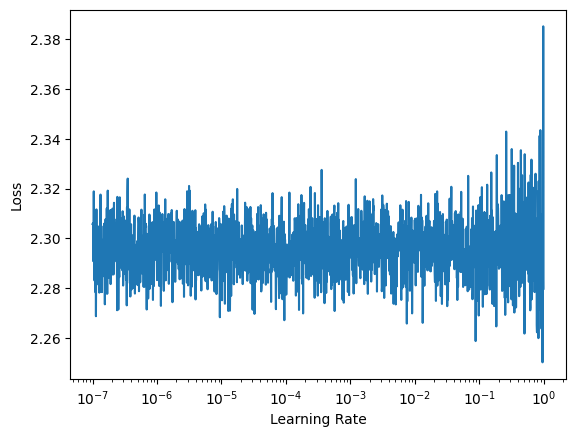

In [15]:
plt.plot(lr_record, loss_record)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()

In [21]:
epochs = 20
# batch_size = 32
num_hidden_layers = 3
hidden_layers_neurons = (10, 7, 3)

In [22]:
from torch.optim import lr_scheduler

optimal_lr =  1e-2
optimizer.param_groups[0]['lr'] = optimal_lr


scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=30)
model.train()


for epoch in range(epochs):
    for images, labels in tqdm(train_loader):

        images = images.view(-1, 784)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))


100%|██████████| 1875/1875 [00:08<00:00, 220.95it/s]


Epoch 0: SGD lr 0.0100 -> 0.0098


100%|██████████| 1875/1875 [00:07<00:00, 245.06it/s]


Epoch 1: SGD lr 0.0098 -> 0.0097


100%|██████████| 1875/1875 [00:07<00:00, 263.61it/s]


Epoch 2: SGD lr 0.0097 -> 0.0095


100%|██████████| 1875/1875 [00:06<00:00, 281.83it/s]


Epoch 3: SGD lr 0.0095 -> 0.0093


100%|██████████| 1875/1875 [00:06<00:00, 287.50it/s]


Epoch 4: SGD lr 0.0093 -> 0.0092


100%|██████████| 1875/1875 [00:06<00:00, 284.77it/s]


Epoch 5: SGD lr 0.0092 -> 0.0090


100%|██████████| 1875/1875 [00:06<00:00, 274.09it/s]


Epoch 6: SGD lr 0.0090 -> 0.0088


100%|██████████| 1875/1875 [00:06<00:00, 278.53it/s]


Epoch 7: SGD lr 0.0088 -> 0.0087


100%|██████████| 1875/1875 [00:06<00:00, 276.75it/s]


Epoch 8: SGD lr 0.0087 -> 0.0085


100%|██████████| 1875/1875 [00:07<00:00, 243.73it/s]


Epoch 9: SGD lr 0.0085 -> 0.0083


100%|██████████| 1875/1875 [00:08<00:00, 227.76it/s]


Epoch 10: SGD lr 0.0083 -> 0.0082


100%|██████████| 1875/1875 [00:07<00:00, 244.87it/s]


Epoch 11: SGD lr 0.0082 -> 0.0080


100%|██████████| 1875/1875 [00:07<00:00, 266.10it/s]


Epoch 12: SGD lr 0.0080 -> 0.0078


100%|██████████| 1875/1875 [00:08<00:00, 212.41it/s]


Epoch 13: SGD lr 0.0078 -> 0.0077


100%|██████████| 1875/1875 [00:07<00:00, 253.06it/s]


Epoch 14: SGD lr 0.0077 -> 0.0075


100%|██████████| 1875/1875 [00:07<00:00, 266.11it/s]


Epoch 15: SGD lr 0.0075 -> 0.0073


100%|██████████| 1875/1875 [00:07<00:00, 263.38it/s]


Epoch 16: SGD lr 0.0073 -> 0.0072


100%|██████████| 1875/1875 [00:07<00:00, 264.50it/s]


Epoch 17: SGD lr 0.0072 -> 0.0070


100%|██████████| 1875/1875 [00:06<00:00, 294.42it/s]


Epoch 18: SGD lr 0.0070 -> 0.0068


100%|██████████| 1875/1875 [00:06<00:00, 295.70it/s]

Epoch 19: SGD lr 0.0068 -> 0.0067


In [23]:
# Evaluation
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 784)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print("Accuracy: {:.2f}%".format(accuracy))

Accuracy: 15.78%


### Q3

3. In this coding exercise, you'll have an opportunity to explore the behavior of a deep neural network trained on the CIFAR10 image dataset. Follow the steps below:

* a. Construct a deep neural network (DNN) using 20 hidden layers, each comprising 100 neurons. To facilitate this exploration, employ the Swish activation function for each layer. Utilize nn.ModuleList to manage the layers effectively.

* b. Load the CIFAR10 dataset for training your network. Utilize the appropriate function, such as torchvision.datasets.CIFAR10. The dataset consists of 60,000 color images, with dimensions of 32×32 pixels. It is divided into 50,000 training samples and 10,000 testing samples. With 10 classes in the dataset, ensure that your network has a softmax output layer comprising 10 neurons. When modifying the model's architecture or hyperparameters, conduct a search to identify an appropriate learning rate. Implement early stopping during training and employ the Nadam optimization algorithm.

* c. Experiment by adding batch normalization to your network. Compare the learning curves obtained with and without batch normalization. Analyze whether the model converges faster with batch normalization and observe any improvements in its performance. Additionally, assess the impact of batch normalization on training speed.

* d. As an additional experiment, substitute batch normalization with SELU (Scaled Exponential Linear Units). Make the necessary adjustments to ensure the network self-normalizes. This involves standardizing the input features, initializing the network's weights using LeCun normal initialization (nn.init.kaiming_normal_), and ensuring that the DNN consists solely of dense layers. Observe the effects of utilizing SELU activation and self-normalization on the network's training stability and performance.

In [29]:
class DNN(nn.Module):
    def __init__(self, input_size: int, output_size: int, num_hidden_layers: int, neurons_per_layer: int, activation_function: Callable, batch_normalization: bool, parameters_initialization: bool=False, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.activation_function = activation_function

        self.input_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_size, out_features=neurons_per_layer),
            activation_function())

        if batch_normalization:
            self.hidden_layers = nn.ModuleList(
                [nn.Sequential(
                    nn.Linear(neurons_per_layer, neurons_per_layer),
                    nn.BatchNorm1d(neurons_per_layer),
                    activation_function())
                    for i in range(num_hidden_layers)])
        else:
            self.hidden_layers = nn.ModuleList(
                [nn.Sequential(
                    nn.Linear(neurons_per_layer, neurons_per_layer),
                    activation_function())
                    for i in range(num_hidden_layers)])

        self.output_layer = nn.Sequential(
            nn.Linear(in_features=neurons_per_layer, out_features=output_size),
            nn.Softmax())
        
        if parameters_initialization:
            self.init_params()

    def init_params(self):
        for n, p in self.named_parameters():
            if 'weight' in n:
                nn.init.kaiming_normal_(p, nonlinearity=self.activation_function().__class__.__name__.lower())
            elif 'bias' in n:
                nn.init.constant_(p, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input_layer(x)
        for module in self.hidden_layers:
            x = module(x)
        return self.output_layer(x)

    def fit(self, train_dl, val_dl, optimizer, criterion, device="cpu", n_epochs=5):
        self.best_loss = float('inf')
        self.patience_counter = 0
        self.best_model_weights = copy.deepcopy(model.state_dict())
        train_losses = []
        val_losses = []

        for epoch in range(n_epochs):
            epoch_train_loss = self.train_epoch(
                train_dl, optimizer, criterion, device)
            train_losses.append(epoch_train_loss)

            epoch_val_loss = self.validate_epoch(val_dl, criterion, device)
            val_losses.append(epoch_val_loss)

            if self.early_stopping(epoch_val_loss):
                print(f'Early stopping at epoch {epoch}')
                break
        
        self.load_state_dict(self.best_model_weights)
        return train_losses, val_losses

    def train_epoch(self, train_dloader, optimizer, criterion, device):
        self.train()
        total_train_loss = 0

        for train_inputs, train_labels in tqdm(train_dloader):
            train_inputs = train_inputs.to(device)
            train_labels = train_labels.to(device)
            predictions = self(train_inputs)
            loss = criterion(predictions, train_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dloader)
        return avg_train_loss

    @torch.no_grad()
    def validate_epoch(self, val_dloader, criterion, device):
        self.eval()
        total_val_loss = 0

        for val_inputs, val_labels in tqdm(val_dloader):
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            predictions = self(val_inputs)
            val_loss = criterion(predictions, val_labels)
            total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_dloader)
        return avg_val_loss
    
    def early_stopping(self, epoch_val_loss, patience=10):
        if epoch_val_loss < self.best_loss:
            self.best_loss = epoch_val_loss
            self.best_model_weights = copy.deepcopy(self.state_dict())
            self.patience_counter = 0
        else:
            self.patience_counter += 1

        if self.patience_counter >= patience:
            return True
        
        return False

In [14]:
train_dataset = datasets.CIFAR10(root="../data", train=True, download=True, transform=ToTensor())
test_dataset = datasets.CIFAR10(root="../data/", train=False, download=True, transform=ToTensor())

train_ds, val_ds = random_split(train_dataset, [40_000, 10_000])

Files already downloaded and verified
Files already downloaded and verified


In [26]:
learning_rate = 0.01
epochs = 10
batch_size = 32
num_hidden_layers = 20
neurons_per_layer = 100
input_size = 32 * 32 * 3
output_size = 10
activation_function = nn.SiLU

In [16]:
train_dloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [17]:
model = DNN(input_size, output_size, num_hidden_layers, neurons_per_layer, activation_function, batch_normalization=False).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.NAdam(model.parameters(), lr=learning_rate)

In [18]:
train_losses, val_losses = model.fit(train_dloader, val_dloader, optimizer, criterion, device, epochs)

  0%|          | 0/1250 [00:00<?, ?it/s]/home/fatemeh/Documents/DeepLearning/DeepLearning-venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 1/1250 [00:00<02:40,  7.77it/s]

100%|██████████| 313/313 [00:10<00:00, 29.66it/s]


In [19]:
def plot_losses(losses, labels, title=None, figsize=(10, 5)):

    fig, ax = plt.subplots(figsize=figsize)
    for loss, label in zip(losses, labels):
        ax.plot(loss, label=label)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.grid()
    ax.legend(loc='upper right')

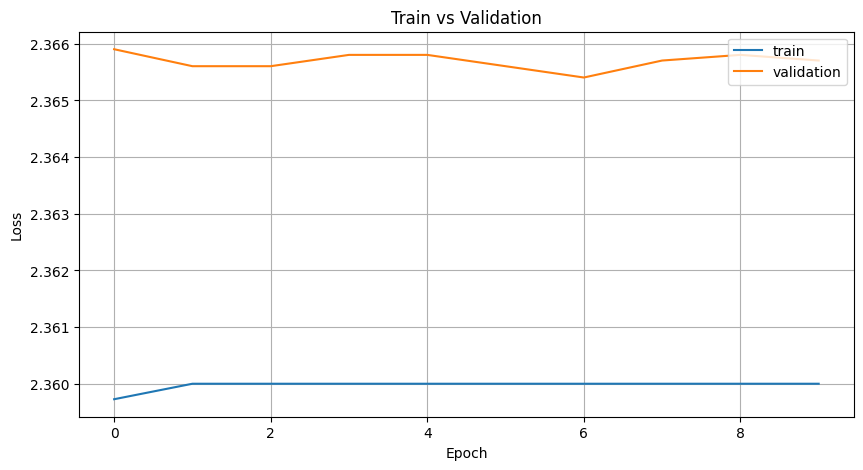

In [20]:
losses = [train_losses, val_losses]
labels = ['train', 'validation']

plot_losses(losses, labels, 'Train vs Validation')

In [24]:
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
results = {}

for lr in learning_rates:
    test_model = DNN(input_size, output_size, num_hidden_layers, neurons_per_layer, activation_function, batch_normalization=False).to(device)
    test_optimizer = optim.NAdam(model.parameters(), lr)
    test_criterion = nn.CrossEntropyLoss().to(device)

    epoch_train_loss = test_model.train_epoch(train_dloader, test_optimizer, test_criterion, device)
    epoch_val_loss = test_model.validate_epoch(val_dloader, test_criterion, device)

    results[lr] = epoch_val_loss

optimal_lr = min(results, key=results.get)
print(f"Optimal Learning Rate: {optimal_lr}")

  0%|          | 0/1250 [00:00<?, ?it/s]/home/fatemeh/Documents/DeepLearning/DeepLearning-venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  1%|          | 8/1250 [00:00<01:02, 20.03it/s]

100%|██████████| 313/313 [00:10<00:00, 30.65it/s]

Optimal Learning Rate: 0.1


In [30]:
model2 = DNN(input_size, output_size, num_hidden_layers, neurons_per_layer, activation_function, batch_normalization=True).to(device)

criterion2 = nn.CrossEntropyLoss().to(device)
optimizer2 = optim.NAdam(model.parameters(), lr=learning_rate)

In [31]:
train_losses2, val_losses2 = model2.fit(train_dloader, val_dloader, optimizer2, criterion2, device, epochs)

  0%|          | 0/1250 [00:00<?, ?it/s]/home/fatemeh/Documents/DeepLearning/DeepLearning-venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 4/1250 [00:00<01:03, 19.67it/s]

100%|██████████| 313/313 [00:10<00:00, 29.25it/s]


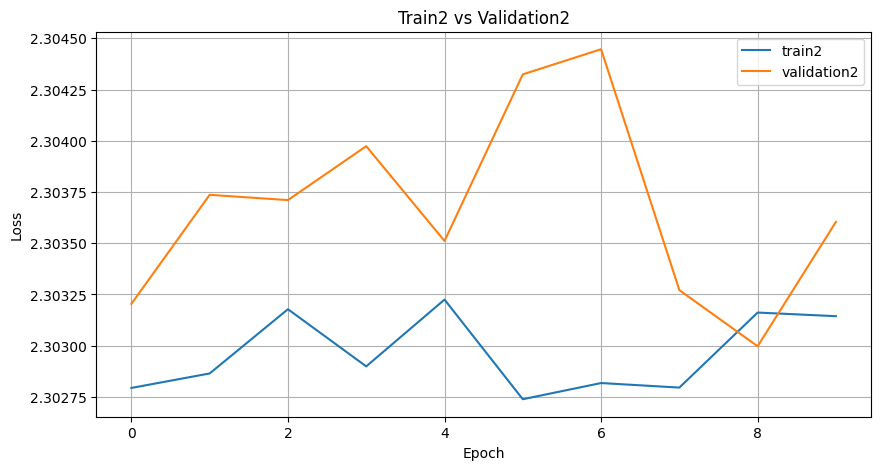

In [32]:
losses2 = [train_losses2, val_losses2]
labels2 = ['train2', 'validation2']

plot_losses(losses2, labels2, 'Train2 vs Validation2')

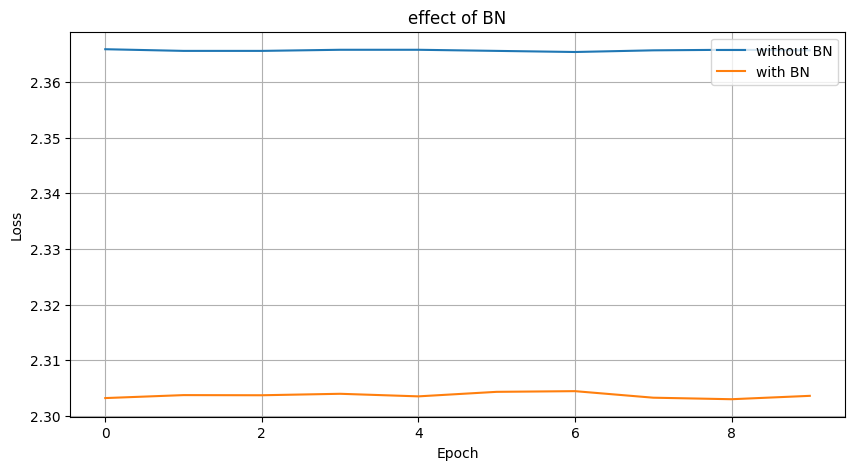

In [33]:
losses1_2 = [val_losses, val_losses2]
labels1_2 = ['without BN', 'with BN']

plot_losses(losses1_2, labels1_2, 'effect of BN')

In [34]:
train_dataset_temp = datasets.MNIST(
    root="../data", train=True, download=True, transform=None)

mean = train_dataset_temp.data.float().mean()
std = train_dataset_temp.data.float().std()

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize(mean=(mean,), std=(std,))])

train_dataset_normalized = datasets.CIFAR10(root="../data", train=True, download=True, transform=transform)
test_dataset_normalized = datasets.CIFAR10(root="../data/", train=False, download=True, transform=transform)

train_ds_normalized, val_ds_normalized = random_split(train_dataset_normalized, [40_000, 10_000])

train_dloader_normalized = DataLoader(train_ds_normalized, batch_size=batch_size, shuffle=True)
val_dloader_normalized = DataLoader(val_ds_normalized, batch_size=batch_size, shuffle=True)
test_dloader_normalized = DataLoader(test_dataset_normalized, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [35]:
activation_function = nn.SELU
model3 = DNN(input_size, output_size, num_hidden_layers, neurons_per_layer, activation_function, batch_normalization=False, parameters_initialization=True).to(device)

criterion3 = nn.CrossEntropyLoss().to(device)
optimizer3 = optim.NAdam(model.parameters(), lr=learning_rate)

In [36]:
train_losses3, val_losses3 = model3.fit(train_dloader_normalized, val_dloader_normalized, optimizer3, criterion3, device, epochs)

  0%|          | 0/1250 [00:00<?, ?it/s]

100%|██████████| 313/313 [00:14<00:00, 21.71it/s]


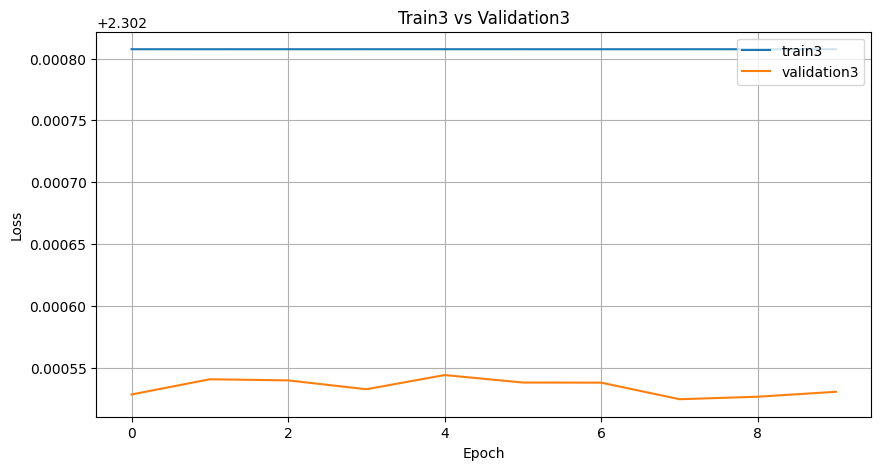

In [37]:
losses3 = [train_losses3, val_losses3]
labels3 = ['train3', 'validation3']

plot_losses(losses3, labels3, 'Train3 vs Validation3')

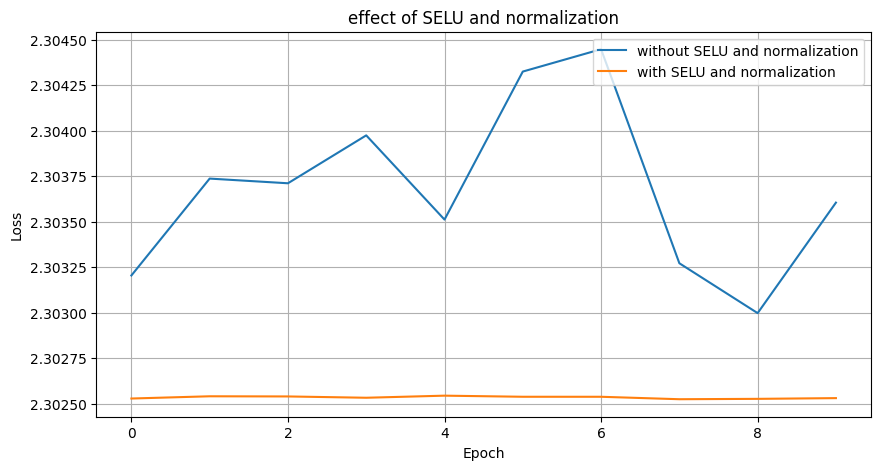

In [38]:
losses2_3 = [val_losses2, val_losses3]
labels2_3 = ['without SELU and normalization', 'with SELU and normalization']

plot_losses(losses2_3, labels2_3, 'effect of SELU and normalization')

In [45]:
final_model = DNN(input_size, output_size, num_hidden_layers, neurons_per_layer, activation_function, batch_normalization=False, parameters_initialization=True).to(device)

final_criterion = nn.CrossEntropyLoss().to(device)
final_optimizer = optim.NAdam(final_model.parameters(), lr=optimal_lr)

final_train_losses, final_val_losses = final_model.fit(train_dloader_normalized, val_dloader_normalized, final_optimizer, final_criterion, device, epochs)

  0%|          | 0/1250 [00:00<?, ?it/s]/home/fatemeh/Documents/DeepLearning/DeepLearning-venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 313/313 [00:19<00:00, 15.75it/s]


In [53]:
accuracy = 100 * check_accuracy(test_dloader_normalized, final_model).item()
print("Accuracy: {:.2f}%".format(accuracy))

/home/fatemeh/Documents/DeepLearning/DeepLearning-venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Accuracy: 10.00%
